# **Limpieza y Organización de Datos PS3**
<br>
Nicolas Lozano, Jhan Pulido, Gerardo Rendon, Samuel Narvaez
<br>
2025-05-06

## Limpiamos ambiente y cargamos paquetes

In [255]:
rm(list = ls())

require(pacman)

p_load(
  "ggplot2",
  "tidyverse",
  "dplyr",
  "visdat",
  "stargazer",
  "leaflet"
)

# Set working directory to the project root
while (tail(strsplit(getwd(), "/")[[1]], 1) != "202510-MLBD-PS3") {
  setwd("..")
}

getwd()

options(
  repr.plot.width  = 10,   # inches  (default is 7)
  repr.plot.height = 6,    # inches  (default is 5)
  repr.plot.res    = 120   # DPI; larger → sharper but heavier files
)

[1] "c:/Users/NicolasLozano/OneDrive - Universidad de los andes/UNIVERSIDAD/9. NOVENO SEMESTRE/BIG DATA/ProblemSets/202510-MLBD-PS3"

## Cargue de datos

In [256]:
test <- read.csv(
  "stores\\test.csv"
)

train <- read.csv(
  "stores\\train.csv"
)

## Organizamos los datos

### Corregimos los tipos de variables

In [257]:
train <- train %>%
  mutate(
    year = as.factor(year),
    month = as.factor(month),
    property_type = as.factor(property_type),
    rooms = as.factor(rooms),
    bathrooms = as.factor(bathrooms),
    bedrooms = as.factor(bedrooms)
)

test <- test %>%
  mutate(
    year = as.factor(year),
    month = as.factor(month),
    property_type = as.factor(property_type),
    rooms = as.factor(rooms),
    bathrooms = as.factor(bathrooms),
    bedrooms = as.factor(bedrooms)
)

### Analizamos Missing Values

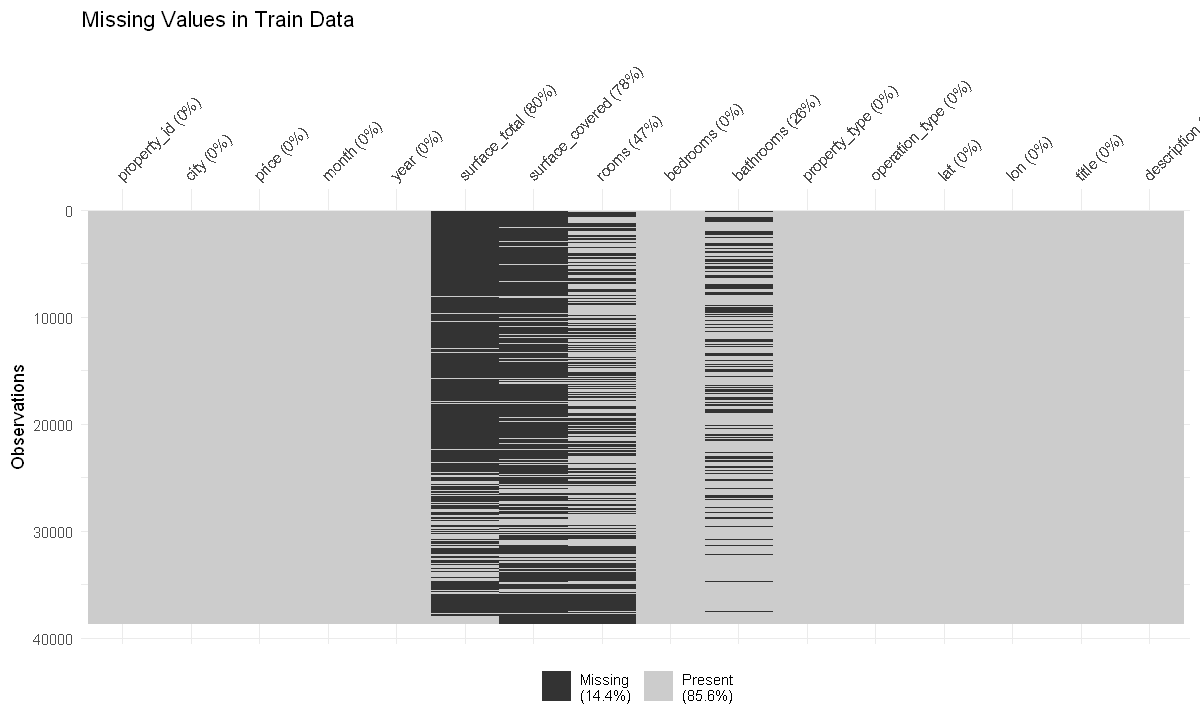

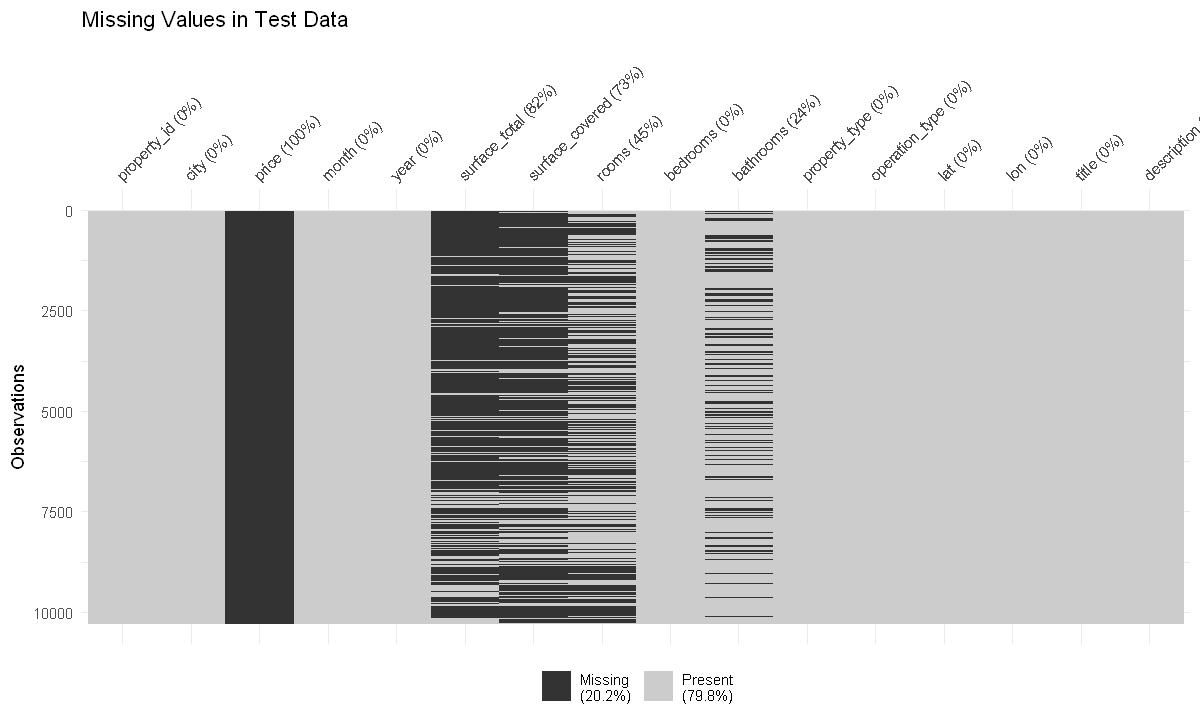

In [258]:
train  <- train %>%
            mutate(
              title = ifelse(is.na(title), "", title),
              description = ifelse(is.na(description), "", description)
            )

test  <- test %>%
            mutate(
              title = ifelse(is.na(title), "", title),
              description = ifelse(is.na(description), "", description)
            )

miss_train  <- vis_miss(train) +
            ggtitle("Missing Values in Train Data")

miss_test  <- vis_miss(test) +
            ggtitle("Missing Values in Test Data")

miss_train
miss_test

Hay un gran numero de missing values en la variables `surface_total`, `surface_covered`, `rooms` y `bathrooms`

### Imputamos valores para variables con gran número de missing values

Para habitaciones y baños usamos la moda al ser variables discretas

In [ ]:
train  <- train %>% 
    mutate(
        rooms = ifelse(is.na(rooms) == T, as.numeric(names(sort(table(rooms))[1])), rooms),
        bathrooms = ifelse(is.na(bathrooms) == T, as.numeric(names(sort(table(bathrooms))[1])), bathrooms)
    )

test  <- test %>% 
    mutate(
        rooms = ifelse(is.na(rooms) == T, as.numeric(names(sort(table(rooms))[1])), rooms),
        bathrooms = ifelse(is.na(bathrooms) == T, as.numeric(names(sort(table(bathrooms))[1])), bathrooms)
    )

In [260]:
train <- train %>%
  mutate(
    rooms = as.integer(as.character(rooms)),
    bathrooms = as.integer(as.character(bathrooms)),
    bedrooms = as.integer(as.character(bedrooms))
)

test <- test %>%
  mutate(
    rooms = as.integer(as.character(rooms)),
    bathrooms = as.integer(as.character(bathrooms)),
    bedrooms = as.integer(as.character(bedrooms))
)

Al imputar utilizando la moda, especialmente para el caso de la variable `rooms` donde el procentaje de valores faltantes esta entre 45% y 47%, se podría estar sesgando la distribución. Se sugiere a futuro escoger otros métodos de imputación que no introduzcan este problema.

Para las variables de superficies al ser variables continuas imputamos utilizando la mediana y un método de regresión.

In [261]:
train  <- train  %>% 
            mutate(
                surface_covered_reg = surface_covered,
                surface_total_reg = surface_total,
            )

test  <- test  %>% 
            mutate(
                surface_covered_reg = surface_covered,
                surface_total_reg = surface_total,
            )

Imputación con la mediana

In [262]:
train  <- train  %>% 
            mutate(
                surface_covered = ifelse(is.na(surface_covered) == T, median(surface_covered, na.rm = T), surface_covered),
                surface_total = ifelse(is.na(surface_total) == T, median(surface_total, na.rm = T), surface_total),
            )

test  <- test  %>% 
            mutate(
                surface_covered = ifelse(is.na(surface_covered) == T, median(surface_covered, na.rm = T), surface_covered),
                surface_total = ifelse(is.na(surface_total) == T, median(surface_total, na.rm = T), surface_total),
            )

Imputación con regresión

In [263]:
linear_imput_model_covered  <- lm(
    surface_covered_reg ~ 
        property_type + rooms + bathrooms + bedrooms,
    data = train, na.action = na.exclude
)   

linear_imput_model_total  <- lm(
    surface_total_reg ~ 
        property_type + rooms + bathrooms + bedrooms,
    data = train, na.action = na.exclude
)

train$pred_total  <- predict(
    linear_imput_model_total,
    newdata = train
)

train$pred_covered  <- predict(
    linear_imput_model_covered,
    newdata = train
)

linear_imput_model_covered  <- lm(
    surface_covered_reg ~ 
        property_type + rooms + bathrooms + bedrooms,
    data = test, na.action = na.exclude
)   

linear_imput_model_total  <- lm(
    surface_total_reg ~ 
        property_type + rooms + bathrooms + bedrooms,
    data = test, na.action = na.exclude
)

test$pred_covered  <- predict(
    linear_imput_model_covered,
    newdata = test
)

test$pred_total  <- predict(
    linear_imput_model_total,
    newdata = test
)

train  <- train  %>% 
            mutate(
                surface_covered_reg = ifelse(is.na(surface_covered_reg) == T, pred_covered, surface_covered_reg),
                surface_total_reg = ifelse(is.na(surface_total_reg) == T, pred_total, surface_total_reg)
            )

test  <- test  %>% 
            mutate(
                surface_covered_reg = ifelse(is.na(surface_covered_reg) == T, pred_covered, surface_covered_reg),
                surface_total_reg = ifelse(is.na(surface_total_reg) == T, pred_total, surface_total_reg)
            )


Warning message in predict.lm(linear_imput_model_covered, newdata = test):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"


Dejar las variables `rooms`, `bathrooms` y `bedrooms` como factores arroja error, debido al gran número de missing values en las variables dependientes. Por esto se dejan como enteros. Ahora miramos las distribuciones para las variables imputadas.

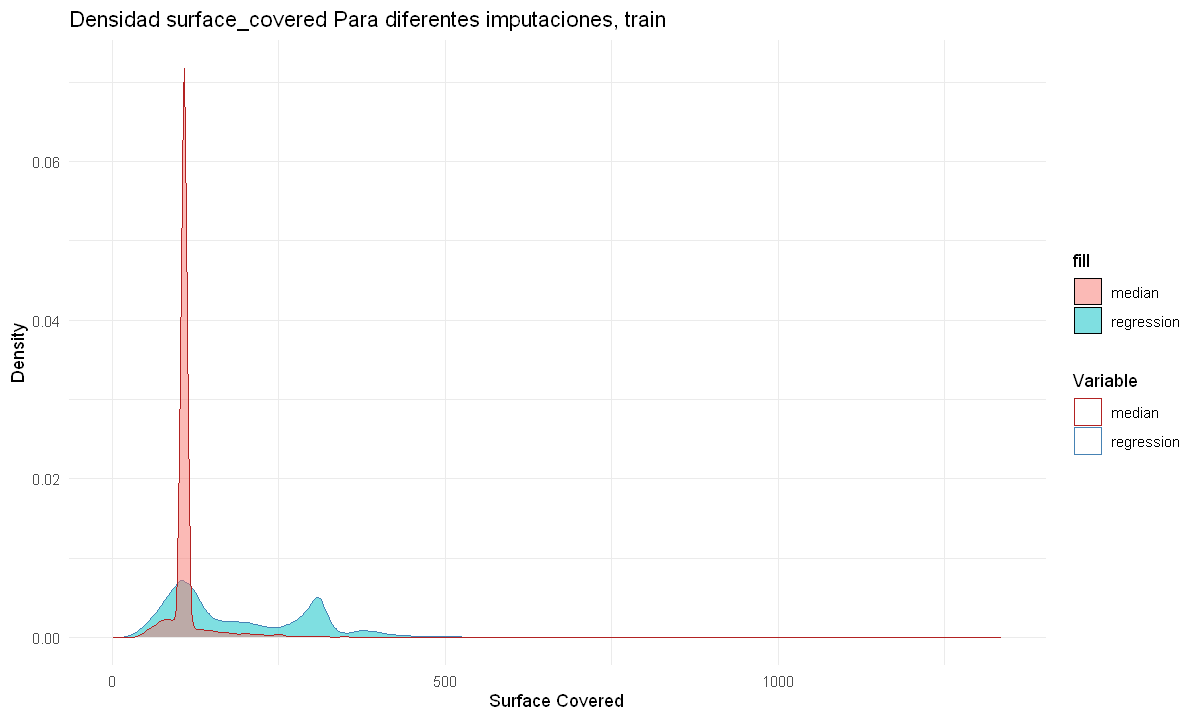

In [264]:
ggplot() +
    geom_density(
        data = train,
        aes(
            x = surface_covered_reg,
            colour = "regression",
            fill = "regression"
        ),
        alpha = 0.5
    ) +
    geom_density(
        data = train,
        aes(
            x = surface_covered,
            colour = "median",
            fill = "median"
        ),
        alpha = 0.5
    ) +
    scale_colour_manual(
        name   = "Variable",                     # legend title
        values = c(regression = "steelblue",
                median = "firebrick")
    ) +
    labs(
        title = "Densidad surface_covered Para diferentes imputaciones, train",
        x = "Surface Covered",
        y = "Density"
    ) +
    theme_minimal() 

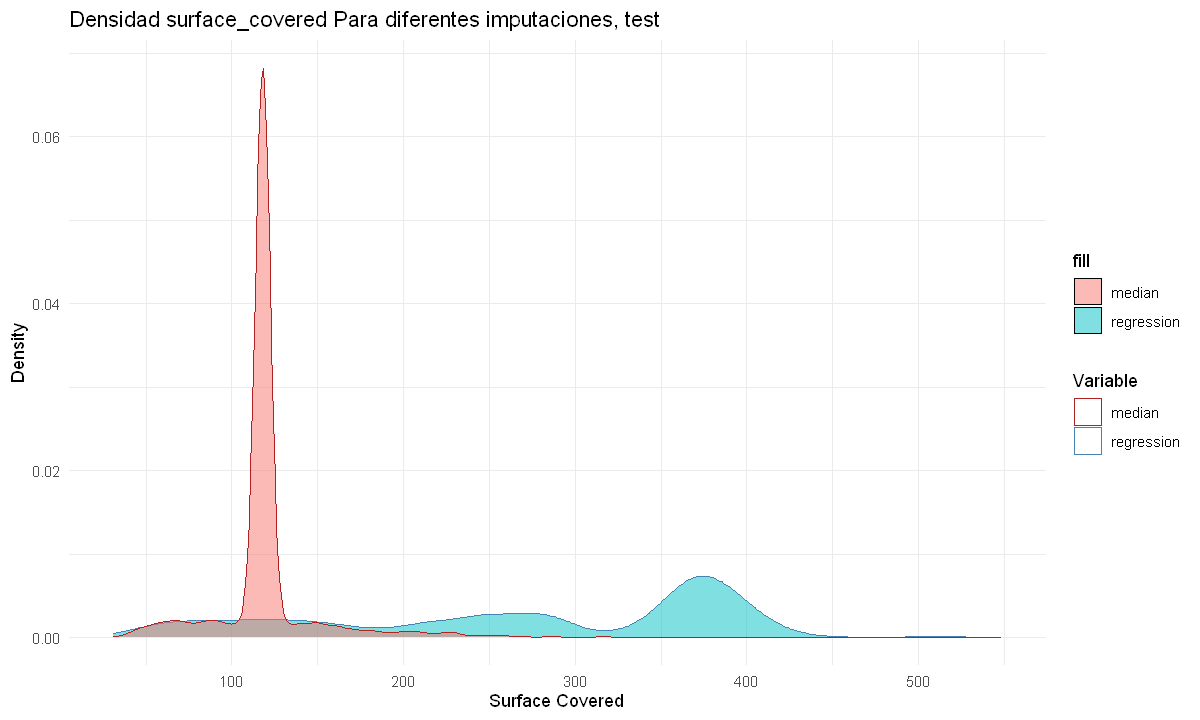

In [265]:
ggplot() +
    geom_density(
        data = test,
        aes(
            x = surface_covered_reg,
            colour = "regression",
            fill = "regression"
        ),
        alpha = 0.5
    ) +
    geom_density(
        data = test,
        aes(
            x = surface_covered,
            colour = "median",
            fill = "median"
        ),
        alpha = 0.5
    ) +
    scale_colour_manual(
        name   = "Variable",
        values = c(regression = "steelblue",
                median = "firebrick")
    ) +
    labs(
        title = "Densidad surface_covered Para diferentes imputaciones, test",
        x = "Surface Covered",
        y = "Density"
    ) +
    theme_minimal() 

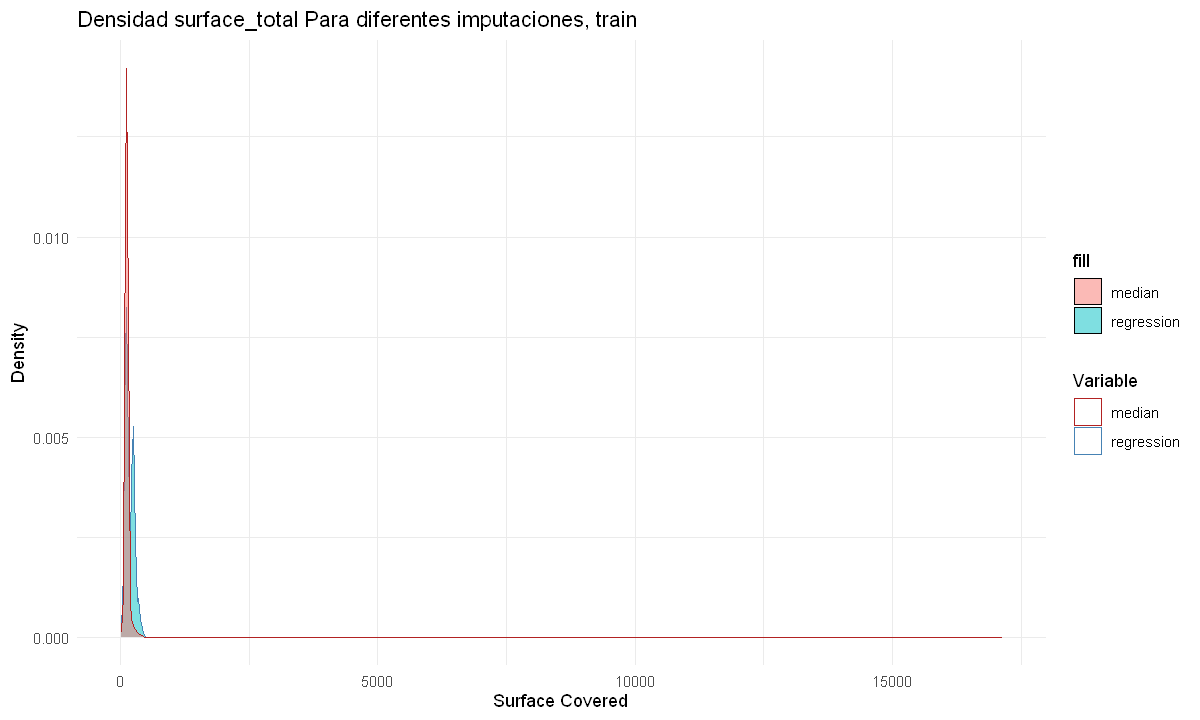

In [266]:
ggplot() +
    geom_density(
        data = train,
        aes(
            x = surface_total_reg,
            colour = "regression",
            fill = "regression"
        ),
        alpha = 0.5
    ) +
    geom_density(
        data = train,
        aes(
            x = surface_total,
            colour = "median",
            fill = "median"
        ),
        alpha = 0.5
    ) +
    scale_colour_manual(
        name   = "Variable",
        values = c(regression = "steelblue",
                median = "firebrick")
    ) +
    labs(
        title = "Densidad surface_total Para diferentes imputaciones, train",
        x = "Surface Covered",
        y = "Density"
    ) +
    theme_minimal() 

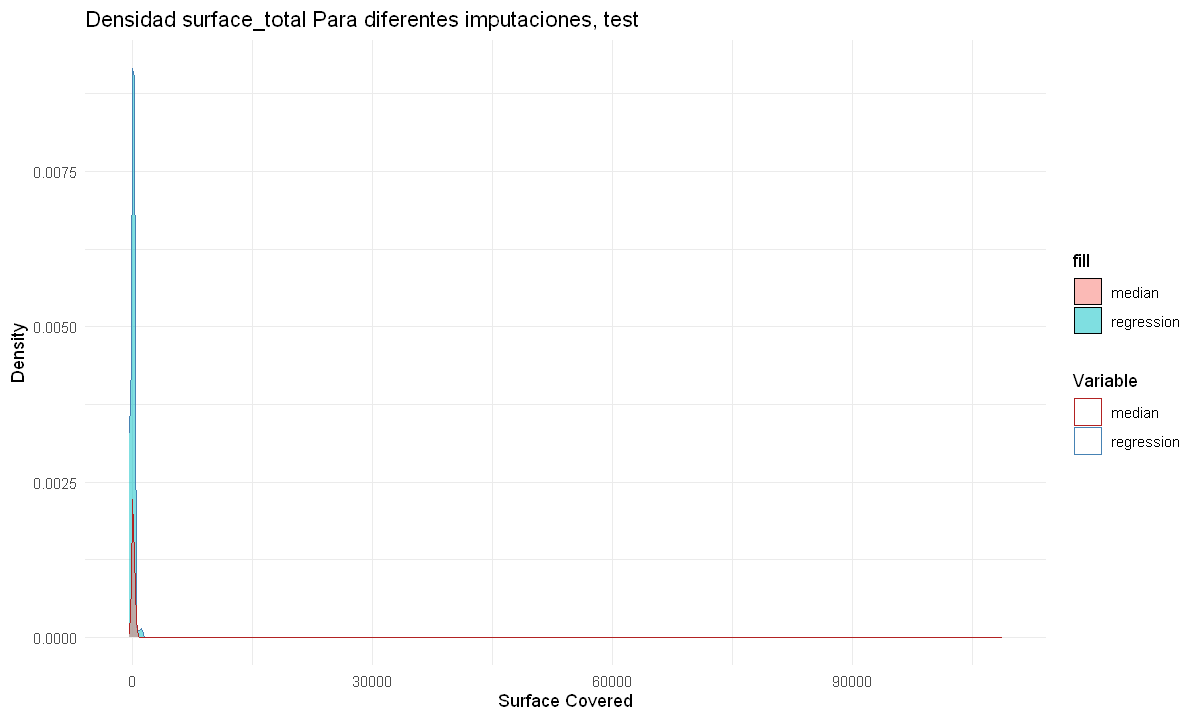

In [267]:
ggplot() +
    geom_density(
        data = test,
        aes(
            x = surface_total_reg,
            colour = "regression",
            fill = "regression"
        ),
        alpha = 0.5
    ) +
    geom_density(
        data = test,
        aes(
            x = surface_total,
            colour = "median",
            fill = "median"
        ),
        alpha = 0.5
    ) +
    scale_colour_manual(
        name   = "Variable",
        values = c(regression = "steelblue",
                median = "firebrick")
    ) +
    labs(
        title = "Densidad surface_total Para diferentes imputaciones, test",
        x = "Surface Covered",
        y = "Density"
    ) +
    theme_minimal() 

### Outliers

En los histogramas anteriores podemos ver que hay poroblemas de valores atipicos, especialmente para `surface_total`. Para manejar estos valores atípicos creamos la variable `precio_por_mt2` que debería solucionar el problema en ambas variables.

Precio Por mt2, area total imputada con la mediana

In [268]:
train <- train %>%
  mutate(precio_por_mt2 = round(price / surface_total, 0))%>%
  mutate(precio_por_mt2  =precio_por_mt2/1000000 ) 
stargazer(train["precio_por_mt2"], type="text")


Statistic        N    Mean  St. Dev.  Min   Max  
-------------------------------------------------
precio_por_mt2 38,644 5.408  2.482   0.020 40.450
-------------------------------------------------


Miramos el histograma

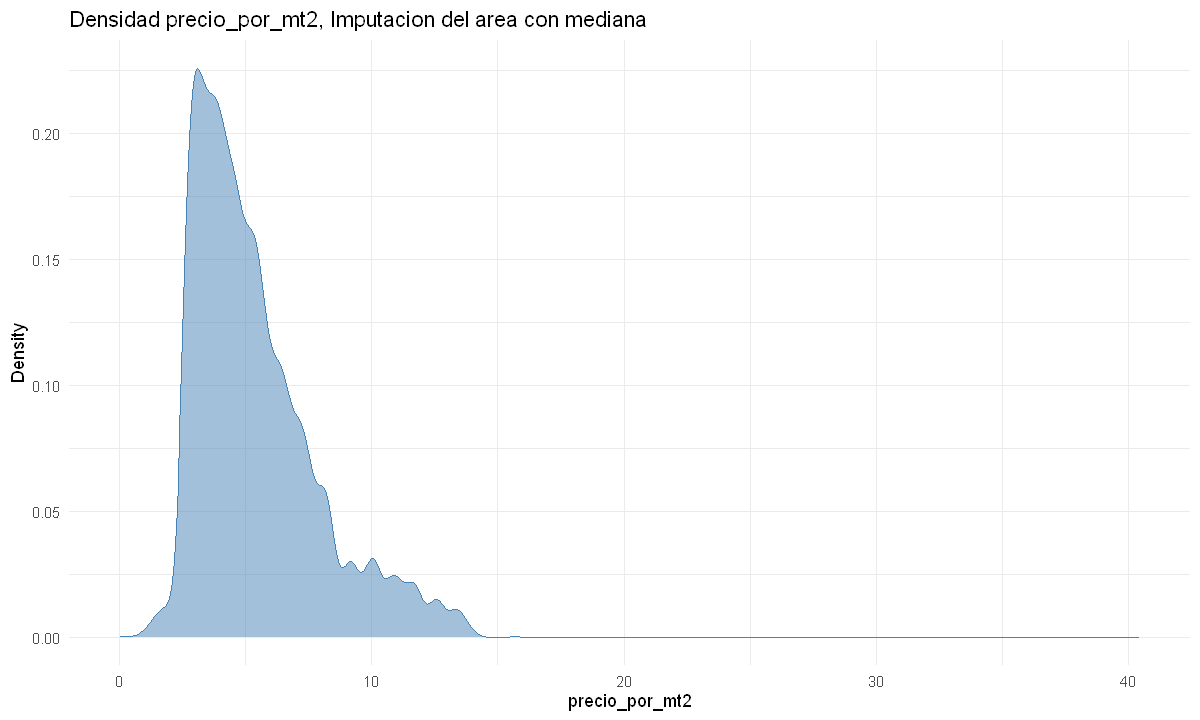

In [269]:
ggplot() +
    geom_density(
        data = train,
        aes(
            x = precio_por_mt2,
        ),
        colour = "steelblue",
        fill = "steelblue",
        alpha = 0.5
    ) +
    labs(
        title = "Densidad precio_por_mt2, Imputacion del area con mediana",
        y = "Density"
    ) +
    theme_minimal() 

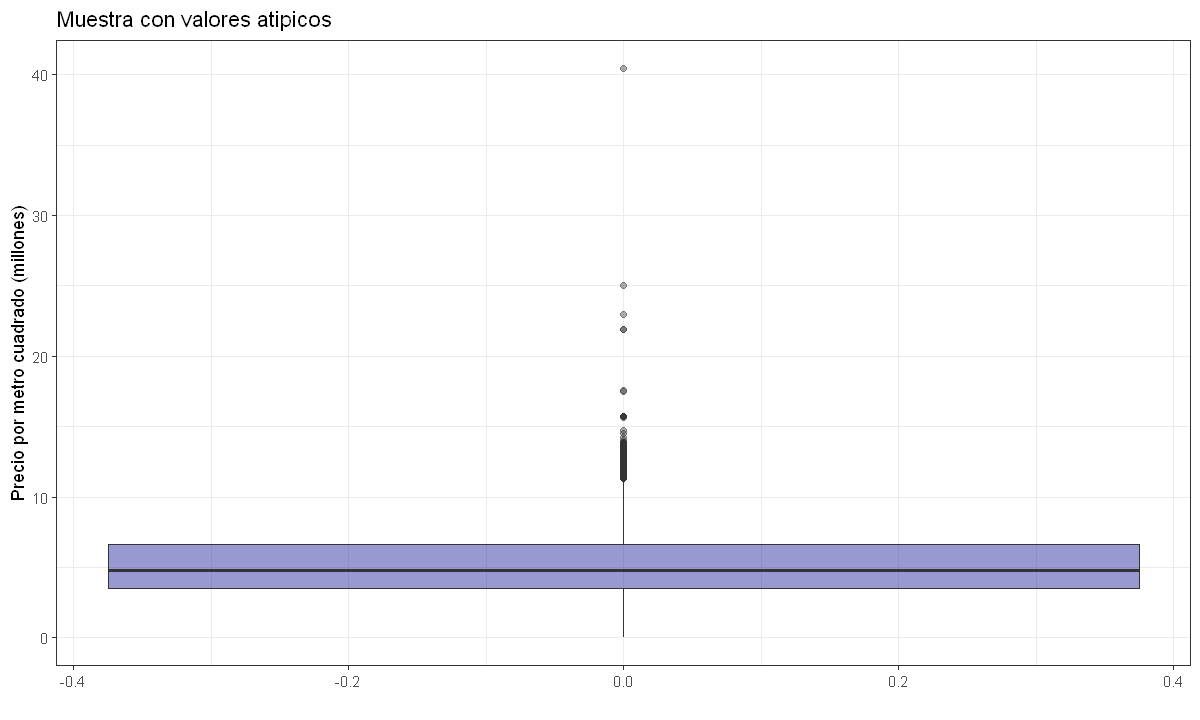

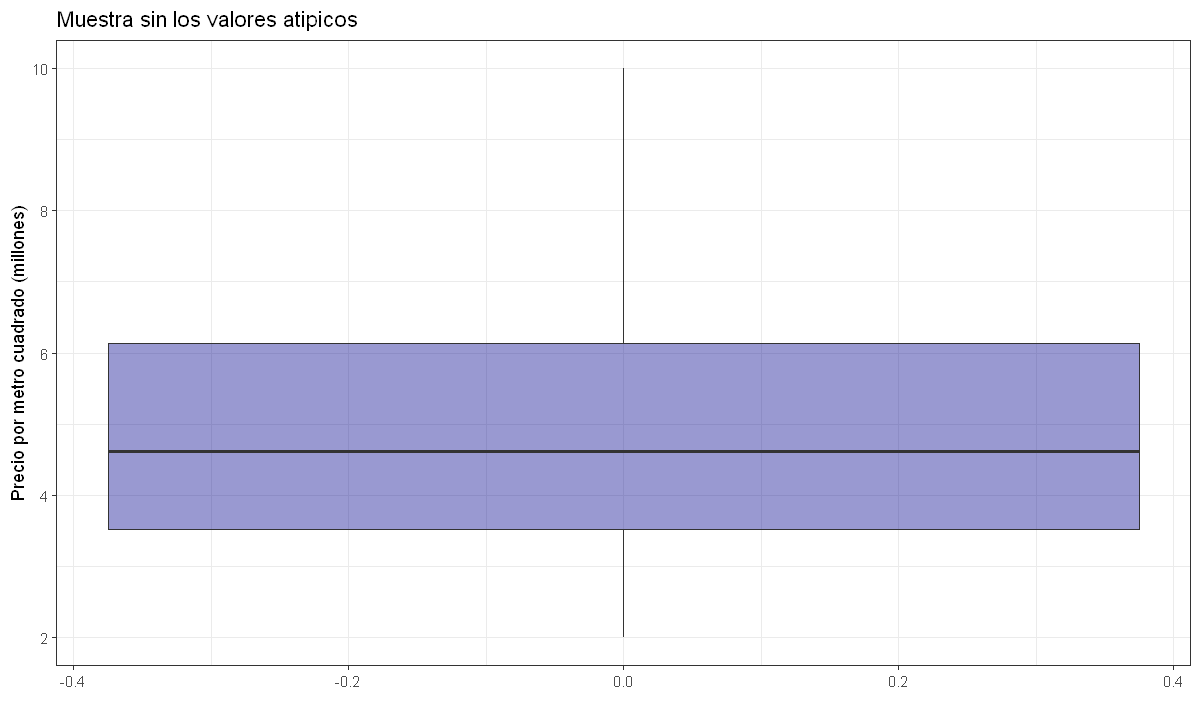

In [270]:
low <- round(mean(train$precio_por_mt2) - 2*sd(train$precio_por_mt2))
up <- round(mean(train$precio_por_mt2) + 2*sd(train$precio_por_mt2))
perc1 <- unname(round(quantile(train$precio_por_mt2, probs = c(.01)),2))

Graph_1 <- train %>%
  ggplot(aes(y = precio_por_mt2)) +
  geom_boxplot(fill = "darkblue", alpha = 0.4) +
  labs(
    title = "Muestra con valores atipicos",
    y = "Precio por metro cuadrado (millones)", x = "") +
  theme_bw()

Graph_2 <- train %>%
  filter(between(precio_por_mt2, perc1,  up)) %>% 
  ggplot(aes(y = precio_por_mt2)) +
  geom_boxplot(fill = "darkblue", alpha = 0.4) +
  labs(
    title = "Muestra sin los valores atipicos",
    y = "Precio por metro cuadrado (millones)", x = "") +
  theme_bw()

Graph_1
Graph_2

train_med <- train %>% filter(between(precio_por_mt2, perc1, up))

Miremos otra vez los histogramas de área.

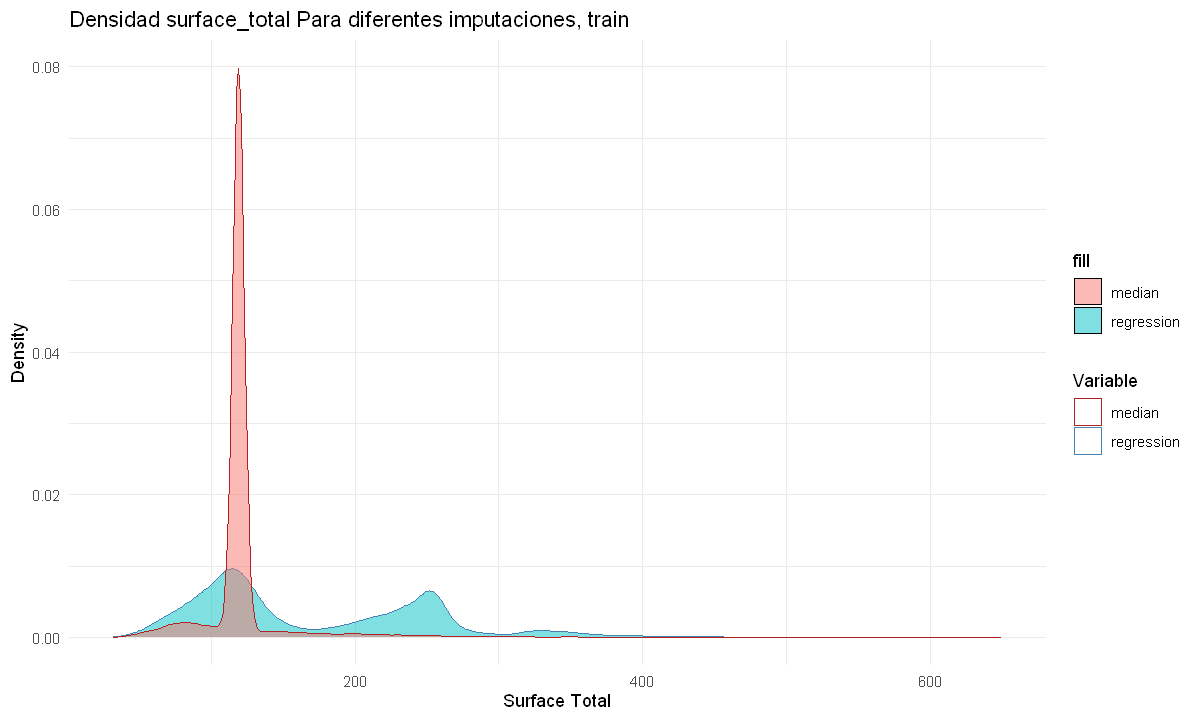

In [271]:
ggplot() +
    geom_density(
        data = train_med,
        aes(
            x = surface_total_reg,
            colour = "regression",
            fill = "regression"
        ),
        alpha = 0.5
    ) +
    geom_density(
        data = train_med,
        aes(
            x = surface_total,
            colour = "median",
            fill = "median"
        ),
        alpha = 0.5
    ) +
    scale_colour_manual(
        name   = "Variable",
        values = c(regression = "steelblue",
                median = "firebrick")
    ) +
    labs(
        title = "Densidad surface_total Para diferentes imputaciones, train",
        x = "Surface Total",
        y = "Density"
    ) +
    theme_minimal() 

Miramos histograma del precio por mt2 despues de filtrar outliers

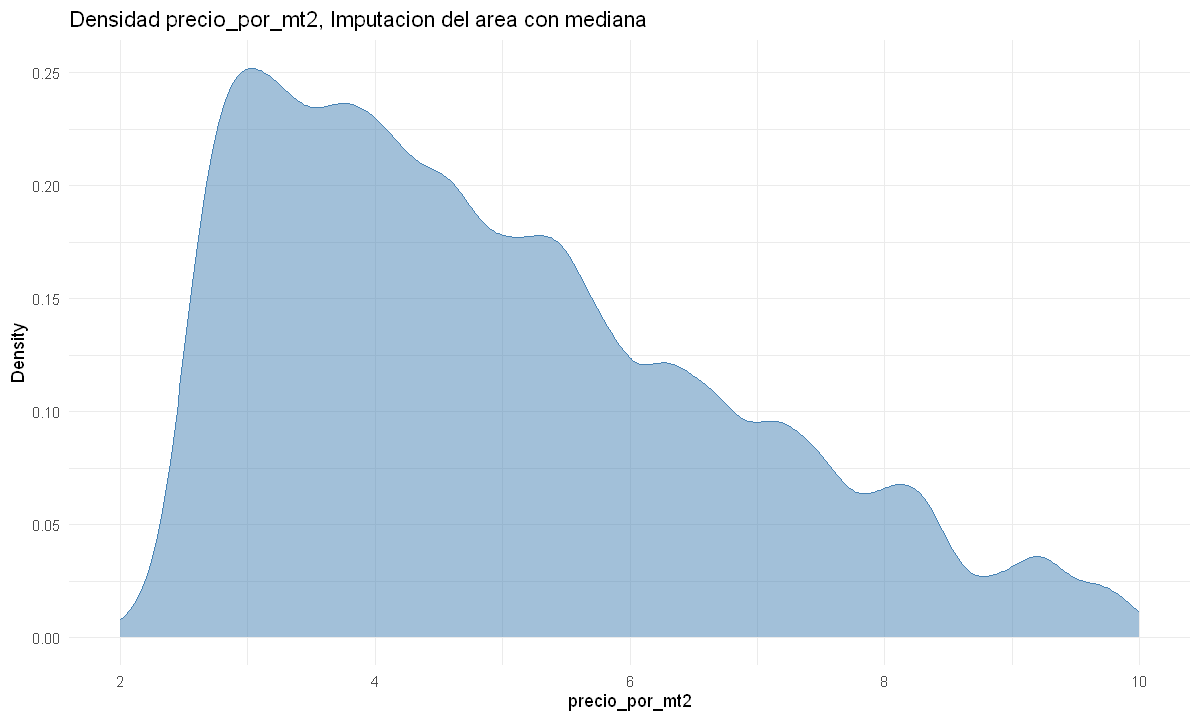

In [272]:
ggplot() +
    geom_density(
        data = train_med,
        aes(
            x = precio_por_mt2,
        ),
        colour = "steelblue",
        fill = "steelblue",
        alpha = 0.5
    ) +
    labs(
        title = "Densidad precio_por_mt2, Imputacion del area con mediana",
        y = "Density"
    ) +
    theme_minimal() 

Precio por mt2 area imputada con regresion

In [273]:
train <- train %>%
  mutate(precio_por_mt2_reg = round(price / surface_total_reg, 0))%>%
  mutate(precio_por_mt2_reg  =precio_por_mt2_reg/1000000 ) 
stargazer(train["precio_por_mt2_reg"], type="text")


Statistic            N    Mean  St. Dev.  Min   Max  
-----------------------------------------------------
precio_por_mt2_reg 38,644 4.310  2.156   0.020 40.450
-----------------------------------------------------


Miramos el histograma del precio por metro cuadrado

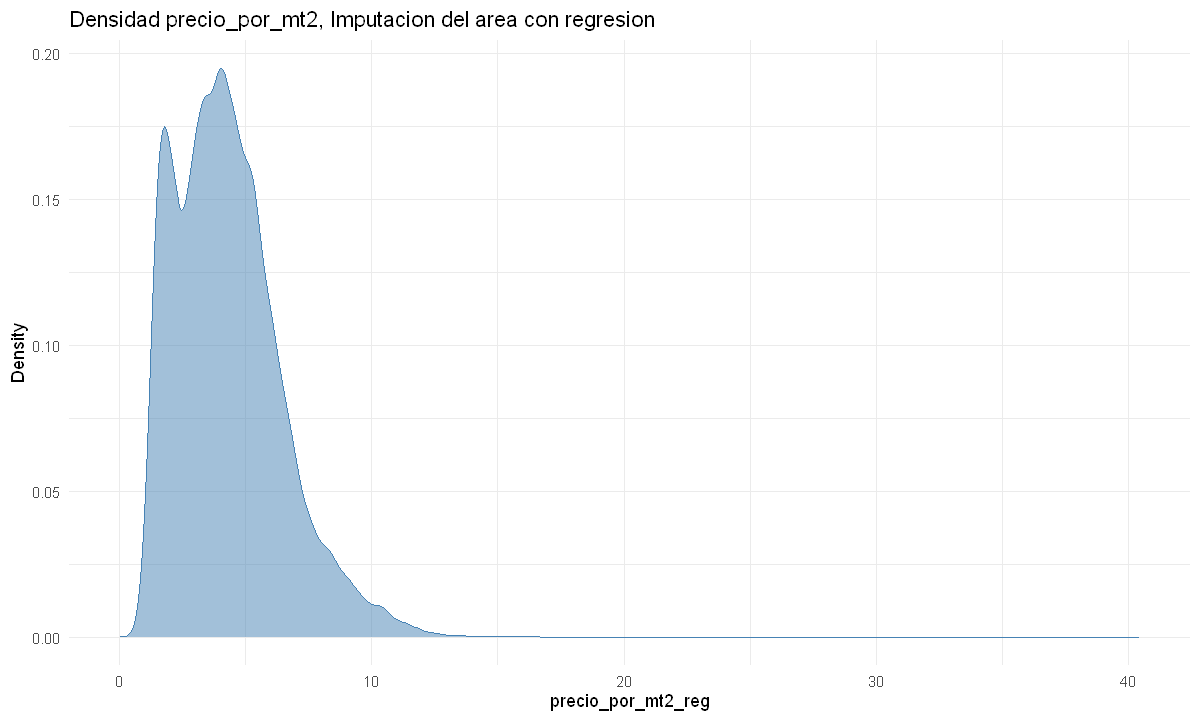

In [274]:
ggplot() +
    geom_density(
        data = train,
        aes(
            x = precio_por_mt2_reg,
        ),
        colour = "steelblue",
        fill = "steelblue",
        alpha = 0.5
    ) +
    labs(
        title = "Densidad precio_por_mt2, Imputacion del area con regresion",
        y = "Density"
    ) +
    theme_minimal() 

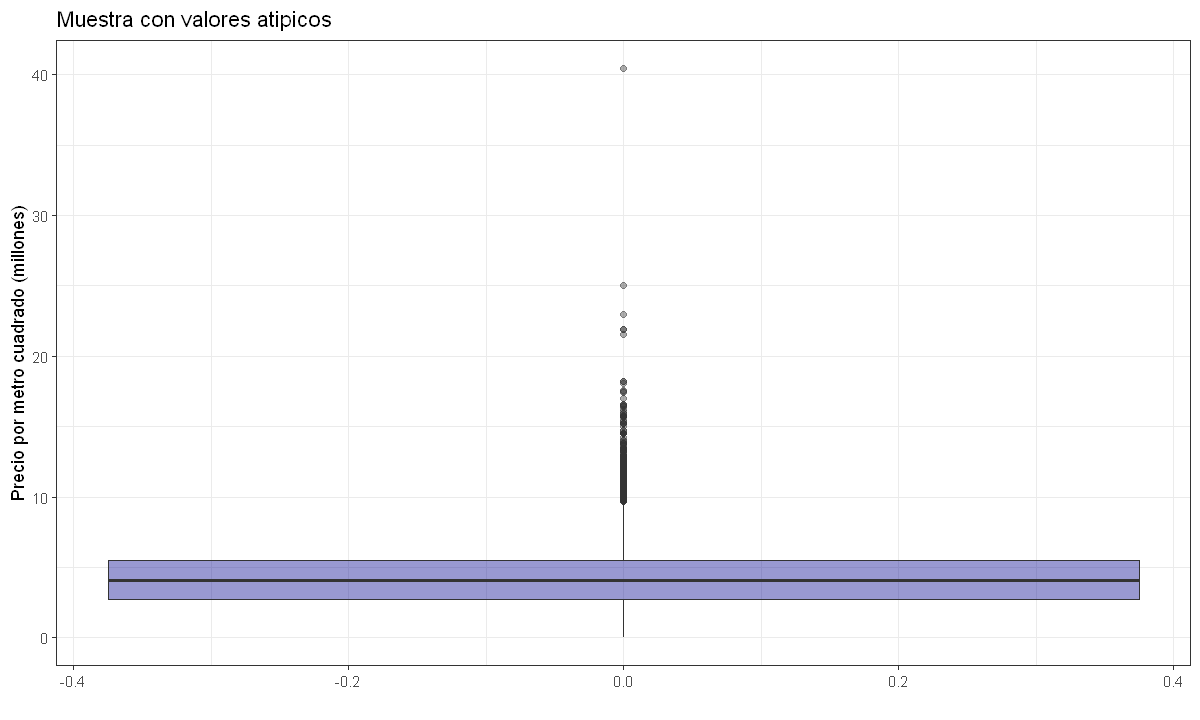

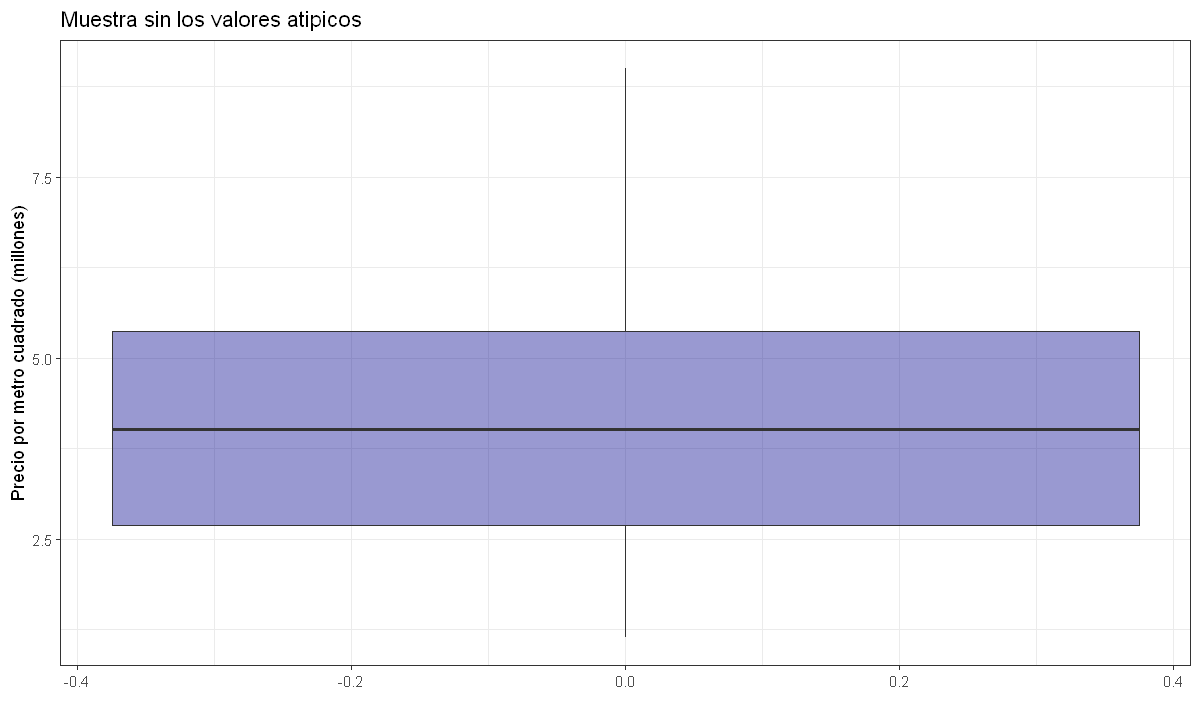

In [275]:
low <- round(mean(train$precio_por_mt2_reg) - 2*sd(train$precio_por_mt2_reg))
up <- round(mean(train$precio_por_mt2_reg) + 2*sd(train$precio_por_mt2_reg))
perc1 <- unname(round(quantile(train$precio_por_mt2_reg, probs = c(.01)),2))
perc2 <- unname(round(quantile(train$precio_por_mt2_reg, probs = c(.99)),2))

Graph_1 <- train %>%
  ggplot(aes(y = precio_por_mt2_reg)) +
  geom_boxplot(fill = "darkblue", alpha = 0.4) +
  labs(
    title = "Muestra con valores atipicos",
    y = "Precio por metro cuadrado (millones)", x = "") +
  theme_bw()

Graph_2 <- train %>%
  filter(between(precio_por_mt2_reg, perc1,  up)) %>% 
  ggplot(aes(y = precio_por_mt2_reg)) +
  geom_boxplot(fill = "darkblue", alpha = 0.4) +
  labs(
    title = "Muestra sin los valores atipicos",
    y = "Precio por metro cuadrado (millones)", x = "") +
  theme_bw()

Graph_1
Graph_2

train_reg <- train %>% filter(between(precio_por_mt2_reg, perc1, up))

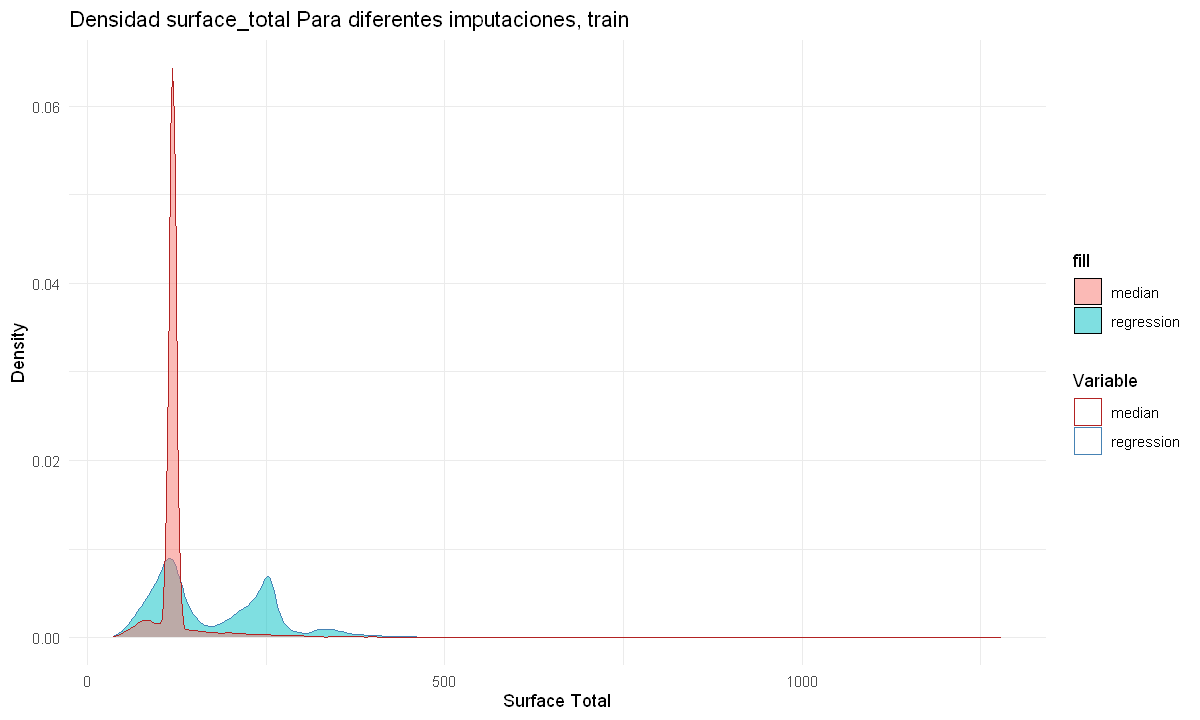

In [276]:
ggplot() +
    geom_density(
        data = train_reg,
        aes(
            x = surface_total_reg,
            colour = "regression",
            fill = "regression"
        ),
        alpha = 0.5
    ) +
    geom_density(
        data = train_reg,
        aes(
            x = surface_total,
            colour = "median",
            fill = "median"
        ),
        alpha = 0.5
    ) +
    scale_colour_manual(
        name   = "Variable",
        values = c(regression = "steelblue",
                median = "firebrick")
    ) +
    labs(
        title = "Densidad surface_total Para diferentes imputaciones, train",
        x = "Surface Total",
        y = "Density"
    ) +
    theme_minimal() 

Miramos nuevamente la distribucion del precio

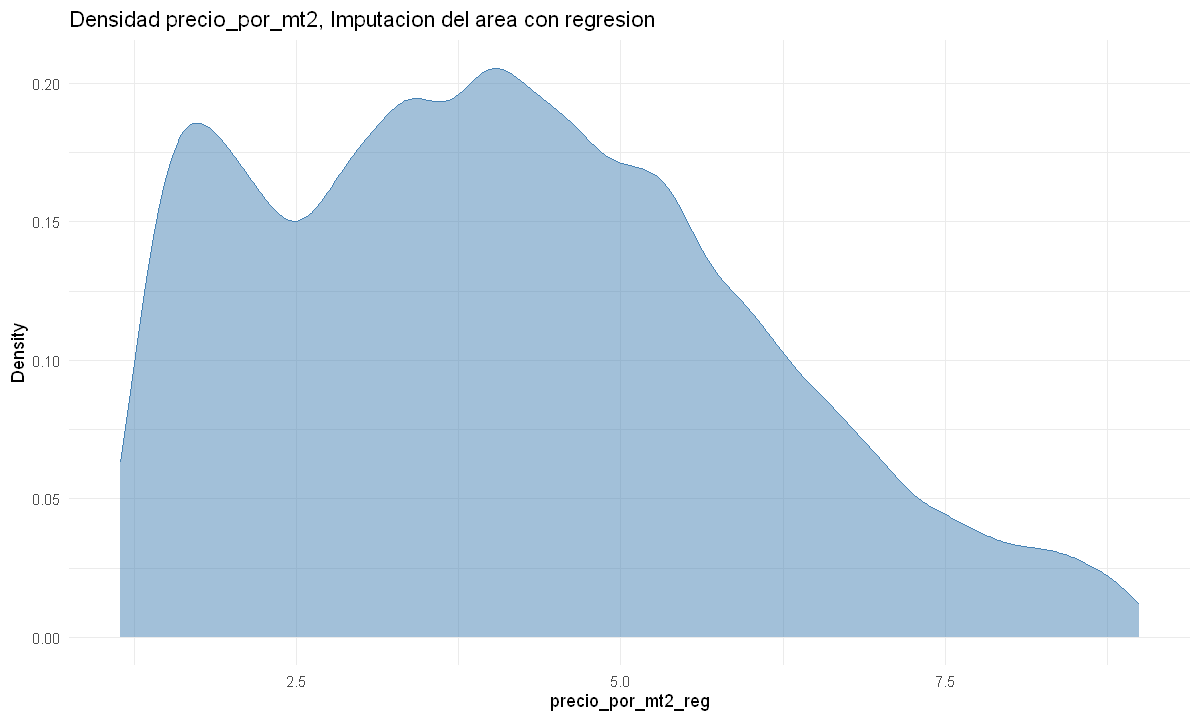

In [277]:
ggplot() +
    geom_density(
        data = train_reg,
        aes(
            x = precio_por_mt2_reg,
        ),
        colour = "steelblue",
        fill = "steelblue",
        alpha = 0.5
    ) +
    labs(
        title = "Densidad precio_por_mt2, Imputacion del area con regresion",
        y = "Density"
    ) +
    theme_minimal() 

### Información espacial

Filtramos observaciones sin coordenadas.

In [278]:
train <- train %>%
  filter(!is.na(lat) & !is.na(lon))
  
test <- test %>%
  filter(!is.na(lat) & !is.na(lon))

In [279]:
leaflet() %>%
  addTiles() %>%
  addCircles(lng = train$lon, 
             lat = train$lat)

HTML widgets cannot be represented in plain text (need html)

Obtenemos limites Bogota

In [280]:
lim <- getbb("Bogota Colombia")
lim

ERROR: Error in getbb("Bogota Colombia"): no se pudo encontrar la función "getbb"
